In [2]:
import numpy as np
import pandas as pd
import copy
import os

In [ ]:
!parallel --jobs 10 < run-state.sh

In [1]:
vax_distribution_by_state = {} 

In [3]:
state_codes = []

for path in os.listdir('../results/centrality_files/'):
    if 'bipartite_normed_product_' in path:
        try: 
            state_codes.append(int(path.split('_')[-1].split('.')[0]))
        except:
            pass

In [4]:
for state_code in state_codes:
    try:
        print(state_code)
        vax_distribution_by_state[state_code] = {}

        dict_param = np.load('../data/state_dict_param/dict_param_%d.npy' % (state_code), allow_pickle=True).item()
        bipartite_normed_product = np.load('../results/centrality_files/bipartite_normed_product_%d.npy' % (state_code), allow_pickle=True)

        ori_sizes = dict_param['cbg_sizes']
        vc = 1 - np.average(dict_param['unvax'], weights=dict_param['cbg_sizes'])

        vaccine_rate_cbg_e = dict_param['unvax']
        vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)
        vax_all = np.flip(np.sort(vaccine_rate_cbg_inter))

        vax_distribution_by_state[state_code]['original'] = copy.deepcopy(vaccine_rate_cbg_inter)
        
        centrality_scores_array = np.array(bipartite_normed_product)

        centrality_scores = {ii: centrality_scores_array[ii] for ii in range(len(centrality_scores_array))}
        centrality_scores = list(reversed(sorted(centrality_scores.items(), key=lambda x: x[1])))

        ii = 0
        for ii in range(0, len(centrality_scores)):
            cbg = centrality_scores[ii][0]
            vaccine_rate_cbg_inter[cbg] = vax_all[ii]        
    
        vax_distribution_by_state[state_code]['order'] = copy.deepcopy(vaccine_rate_cbg_inter)
        vax_distribution_by_state[state_code]['order'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

        vax_distribution_by_state[state_code]['order'] = np.maximum(0, vax_distribution_by_state[state_code]['order'])
        vax_distribution_by_state[state_code]['order'] = np.minimum(1, vax_distribution_by_state[state_code]['order'])

        state_codes = [cbg//10000000000 for cbg in dict_param['cbgs_to_idxs']]
        state_code_set = set(state_codes)

        vax_reverse_all = copy.deepcopy(vaccine_rate_cbg_e)

        for state_code in state_code_set:
            vaxs = np.array([(1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
            vaxs_reverse = np.array([1 - (1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
            cbg_sizes = np.array([dict_param['cbg_sizes'][i] for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
            vaxs_reverse_adjust = vaxs_reverse - np.average(vaxs_reverse, weights=cbg_sizes) + np.average(vaxs, weights=cbg_sizes)

            vaxs_reverse_adjust = np.maximum(0, vaxs_reverse_adjust)
            vaxs_reverse_adjust = np.minimum(1, vaxs_reverse_adjust)

            ii = 0
            for cbg, i in dict_param['cbgs_to_idxs'].items():
                if cbg // 10000000000 == state_code:
                    vax_reverse_all[i] = vaxs_reverse_adjust[ii]
                    ii += 1

        vax_distribution_by_state[state_code]['reverse_within'] = copy.deepcopy(vax_reverse_all)

        vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)

        ii = 0
        for ii in range(int(0.01 * len(centrality_scores)), len(centrality_scores), 2):
            cbg = centrality_scores[ii][0]
            if ii + 1 < len(centrality_scores):
                cbg2 = centrality_scores[ii+1][0]
                tmp = vaccine_rate_cbg_inter[cbg]
                vaccine_rate_cbg_inter[cbg] = vaccine_rate_cbg_inter[cbg2]
                vaccine_rate_cbg_inter[cbg2] = tmp


        vax_distribution_by_state[state_code]['exchange'] = copy.deepcopy(vaccine_rate_cbg_inter)
        vax_distribution_by_state[state_code]['exchange'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

        vax_distribution_by_state[state_code]['exchange'] = np.maximum(0, vax_distribution_by_state[state_code]['exchange'])
        vax_distribution_by_state[state_code]['exchange'] = np.minimum(1, vax_distribution_by_state[state_code]['exchange'])
        
        dict_param['vaccination_rate'] = 1 - vaccine_rate_cbg_e
        np.random.shuffle(dict_param['vaccination_rate'])
        avg = np.average(dict_param['vaccination_rate'], weights=ori_sizes)
        vax_distribution_by_state[state_code]['shuffle'] = dict_param['vaccination_rate'] - avg + vc
    except:
        pass

42
9
39
45
37
30
12
66
13
21
26
28
54
53
78
31
1
6
36
8
38
44
29
55
27
20
69
15
12
60
56
51
23
24
11
16
18
72
35
5
49
2
32
40
47
19
17
10
25
22
50
46
41
33
34
4
48


In [6]:
vax_distribution_by_state[1]['original'].mean(), vax_distribution_by_state[1]['shuffle'].mean()

(0.325490613536258, 0.32677639035184586)

In [7]:
np.save('../results/vax_distribution_by_state.npy', vax_distribution_by_state)

In [36]:
vax_distribution_by_state = np.load('../results/vax_distribution_by_state.npy', allow_pickle=True).item()

In [8]:
vax_distribution_by_state[1]['original'], vax_distribution_by_state[1]['reverse_within']

(array([0.6132713 , 0.49775043, 0.25986378, ..., 0.3024347 , 0.34830467,
        0.3534253 ]),
 array([0.0397002 , 0.15522107, 0.39310772, ..., 0.3505368 , 0.30466683,
        0.2995462 ]))

In [1]:
import os
import numpy as np


In [3]:

results = {}

for path in os.listdir('../results/state-results'):
    if 'results' in path:
        state_code = int(path.split('_')[1])
        if state_code not in results:
            results[state_code] = {}
        tmp = np.load('../results/state-results/'+path, allow_pickle=True).item()[(-1.0, 0.001, 0.005, 120000000.0, 720, False)]
        key = list(tmp.keys())[0]
        results[state_code][key] = tmp[key]

In [49]:
! python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=1 --enable=0 --distribution=original

False 1
[0.3680549  0.33422596 0.33906906 ... 0.3396482  0.377683   0.14170032]
[0.3680549  0.33422596 0.33906906 ... 0.3396482  0.377683   0.14170032]
Adjusted POI transmission rates with dwell time correction factors
Received POI_CBG_VISITS_LIST, will NOT be computing hourly matrices on the fly
=== PARAMETERS ===
poi_psi = 120000000.0, home_beta = 0.005, p_sick_at_t0 = 0.001, num_hours = 720
POI factors (psi * dwell_time_factor / area) for first 10 POIs
[ 7260.48408619  3035.0876308   1110.0889613   1075.02627986
  4815.77039829 16152.51983277    19.10170804  1059.25190334
  2500.07656058   677.06884706]
simulating confirmed cases: True, simulating deaths: True
=== RESULTS (25 seeds) ===
t=  0: L=3041.2 ( 38.4)   I=  0.0 (  0.0)   R=1787073.0 (  0.0)
t= 24: L=2696.3 ( 41.1)   I=342.9 ( 18.0)   R=1787123.8 (  6.4)
t= 48: L=2500.4 ( 35.9)   I=541.6 ( 20.0)   R=1787247.4 ( 12.7)
t= 72: L=2382.7 ( 35.6)   I=658.6 ( 23.0)   R=1787418.2 ( 18.6)
t= 96: L=2324.8 ( 36.1)   I=714.3 ( 22.7)   R

In [4]:
sep = {}

for state_code in results:
    sep[state_code] = {}
    print(state_code,)
    for case in ['original', 'exchange', 'reverse_within', 'shuffle', 'order']:
        sep[state_code][case] = results[state_code][case]['all']['new_cases'][:, :].sum(axis=1)
        print(sep[state_code][case],)
    print()

13
[32486.         32050.         31250.         31508.
 30244.         31344.         30141.99995515 31897.
 32573.         31142.         31029.         33251.
 31889.         33718.         30830.         30776.
 35055.         29748.         34273.         33675.
 33976.         35246.99998505 33728.         32172.
 32044.        ]
[30950. 29427. 30074. 30948. 28141. 31429. 27048. 29620. 29959. 29633.
 30563. 30031. 29555. 30907. 31658. 27995. 33196. 30021. 32373. 29288.
 30877. 29447. 29921. 31778. 27403.]
[45040. 43862. 45254. 47313. 46389. 49038. 46586. 47593. 49015. 47215.
 47774. 46688. 45246. 48630. 45738. 48297. 49047. 48881. 48453. 46869.
 48500. 43548. 47883. 46877. 45942.]
[36023. 34840. 34476. 35623. 35827. 33827. 31285. 36454. 35658. 36373.
 34989. 36791. 37694. 35969. 35184. 34681. 37955. 35271. 34858. 37146.
 38328. 33515. 34608. 37077. 38462.]
[11301. 11697. 11440. 11232. 10867. 11826. 11090. 11479. 11378. 11421.
 11468. 11886. 11535. 11438. 11402. 10226. 12001. 1148

In [5]:
all_text = """Alabama	AL	1
Alaska	AK	2
Arizona	AZ	4
Arkansas	AR	5
Colorado	CO	8
Connecticut	CT	9
Delaware	DE	10
District of Columbia	DC	11
Georgia	GA	13
Hawaii	HI	15
Idaho	ID	16
Illinois	IL	17
Indiana	IN	18
Iowa	IA	19
Kansas	KS	20
Kentucky	KY	21
Louisiana	LA	22
Maine	ME	23
Maryland	MD	24
Massachusetts	MA	25
Michigan	MI	26
Minnesota	MN	27
Mississippi	MS	28
Missouri	MO	29
Montana	MT	30
Nebraska	NE	31
Nevada	NV	32
New Hampshire	NH	33
New Jersey	NJ	34
New Mexico	NM	35
North Carolina	NC	37
North Dakota	ND	38
Ohio	OH	39
Oklahoma	OK	40
Oregon	OR	41
Pennsylvania	PA	42
Rhode Island	RI	44
South Carolina	SC	45
South Dakota	SD	46
Tennessee	TN	47
Utah	UT	49
Vermont	VT	50
Virginia	VA	51
Washington	WA	53
West Virginia	WV	54
Wisconsin	WI	55
Wyoming	WY	56
Texas	TX	48
California	CA	6
New York	NY	36
New Jersey	NJ	34
Florida	FL	12"""

code2state = {}

for line in all_text.split('\n'):
    items = line.split('\t')
    code2state[int(items[-1])] = items[0]

In [6]:
data = []

for state in sep:
    for k in range(25):
        data.append({
            'state': code2state[state],
            'reverse_ratio': (sep[state]['reverse_within'] / sep[state]['original'])[k],
            'exchange_ratio': (sep[state]['exchange'] / sep[state]['original'])[k],
            'shuffle_ratio': (sep[state]['shuffle'] / sep[state]['original'])[k],
            'order_ratio': (sep[state]['order'] / sep[state]['original'])[k]
        })

In [7]:
import pandas as pd

data = pd.DataFrame.from_dict(data)

In [8]:
data

,state,reverse_ratio,exchange_ratio,shuffle_ratio,order_ratio
0,Georgia,1.386443,0.952718,1.108878,0.347873
1,Georgia,1.368549,0.918159,1.087051,0.364961
2,Georgia,1.448128,0.962368,1.103232,0.366080
3,Georgia,1.501619,0.982227,1.130602,0.356481
4,Georgia,1.533825,0.930466,1.184599,0.359311
...,...,...,...,...,...
1245,Idaho,1.061294,0.979569,1.202043,0.661748
1246,Idaho,0.837573,0.875734,0.898239,0.648728
1247,Idaho,1.420469,0.980271,1.181258,0.749692
1248,Idaho,0.996386,1.056627,1.027711,0.660241


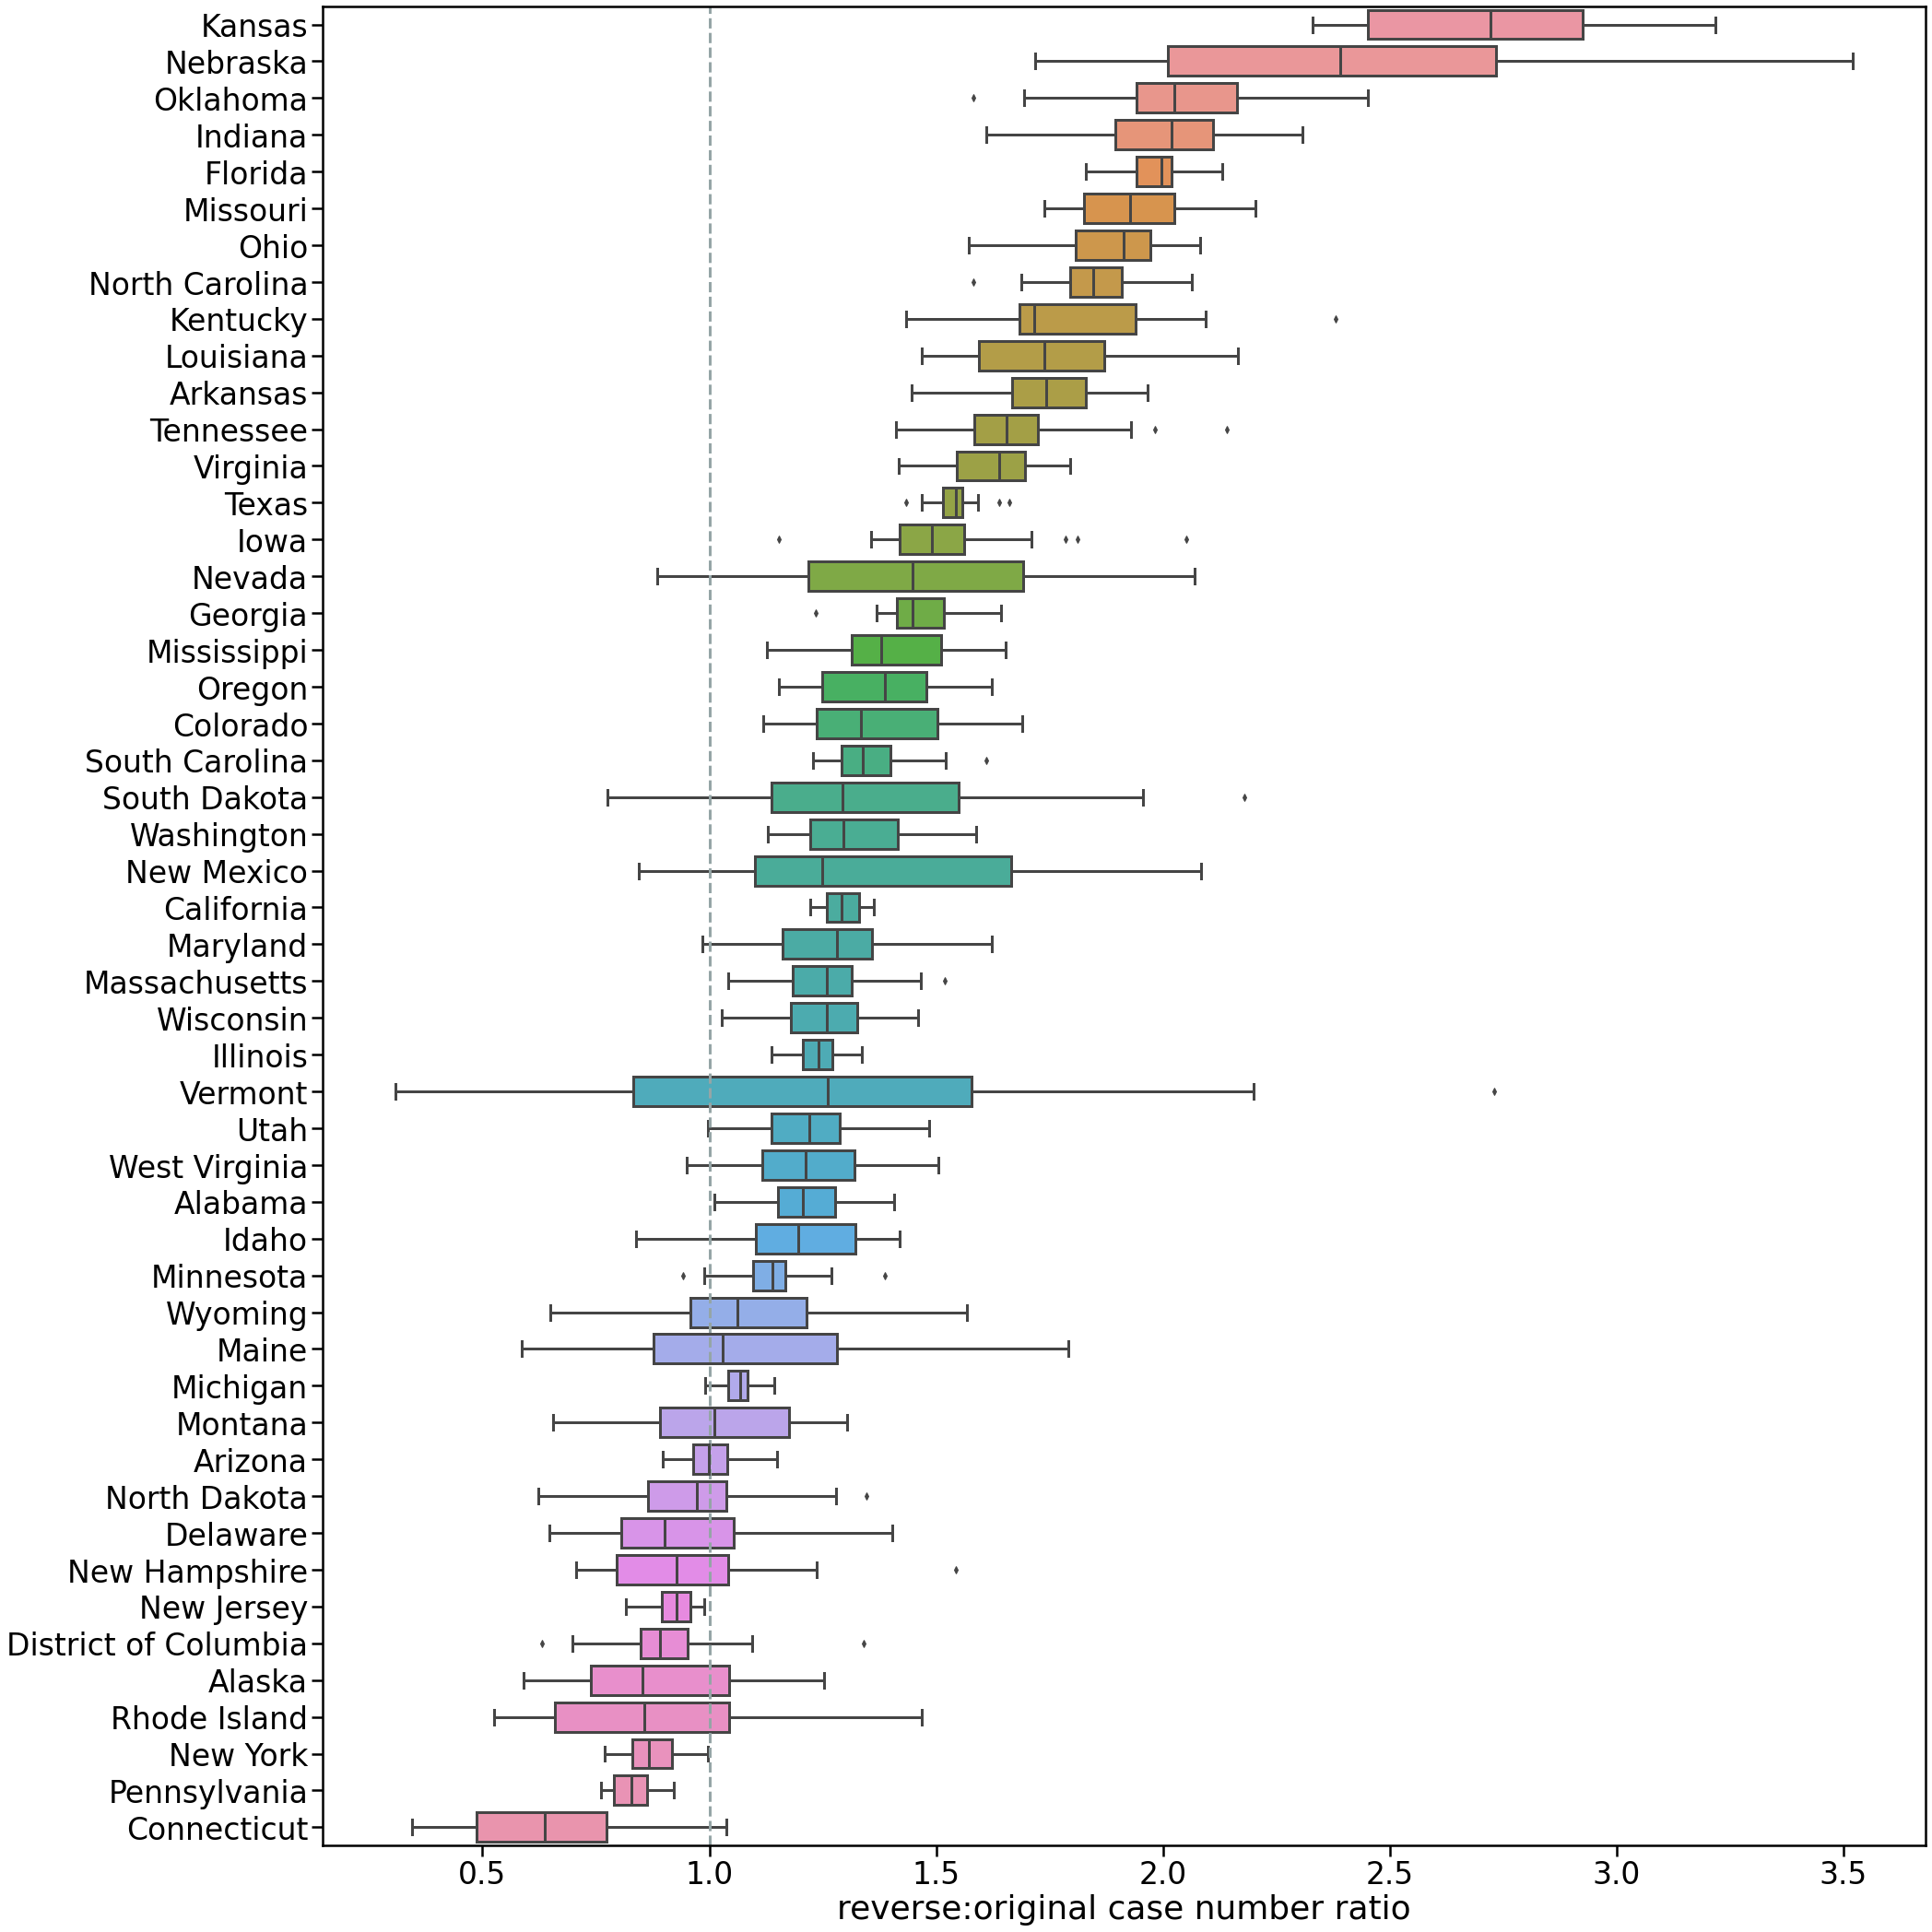

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 30))

sns.set_context('poster', font_scale=1.5)

ranks = data.groupby("state")["reverse_ratio"].mean().fillna(0).sort_values()[::-1].index

sns.boxplot(x='reverse_ratio', y='state', data=data, order=ranks)

plt.xlabel('reverse:original case number ratio')
plt.axvline(1, linestyle='--', color='#95a5a6')
plt.ylabel('')
plt.tight_layout()


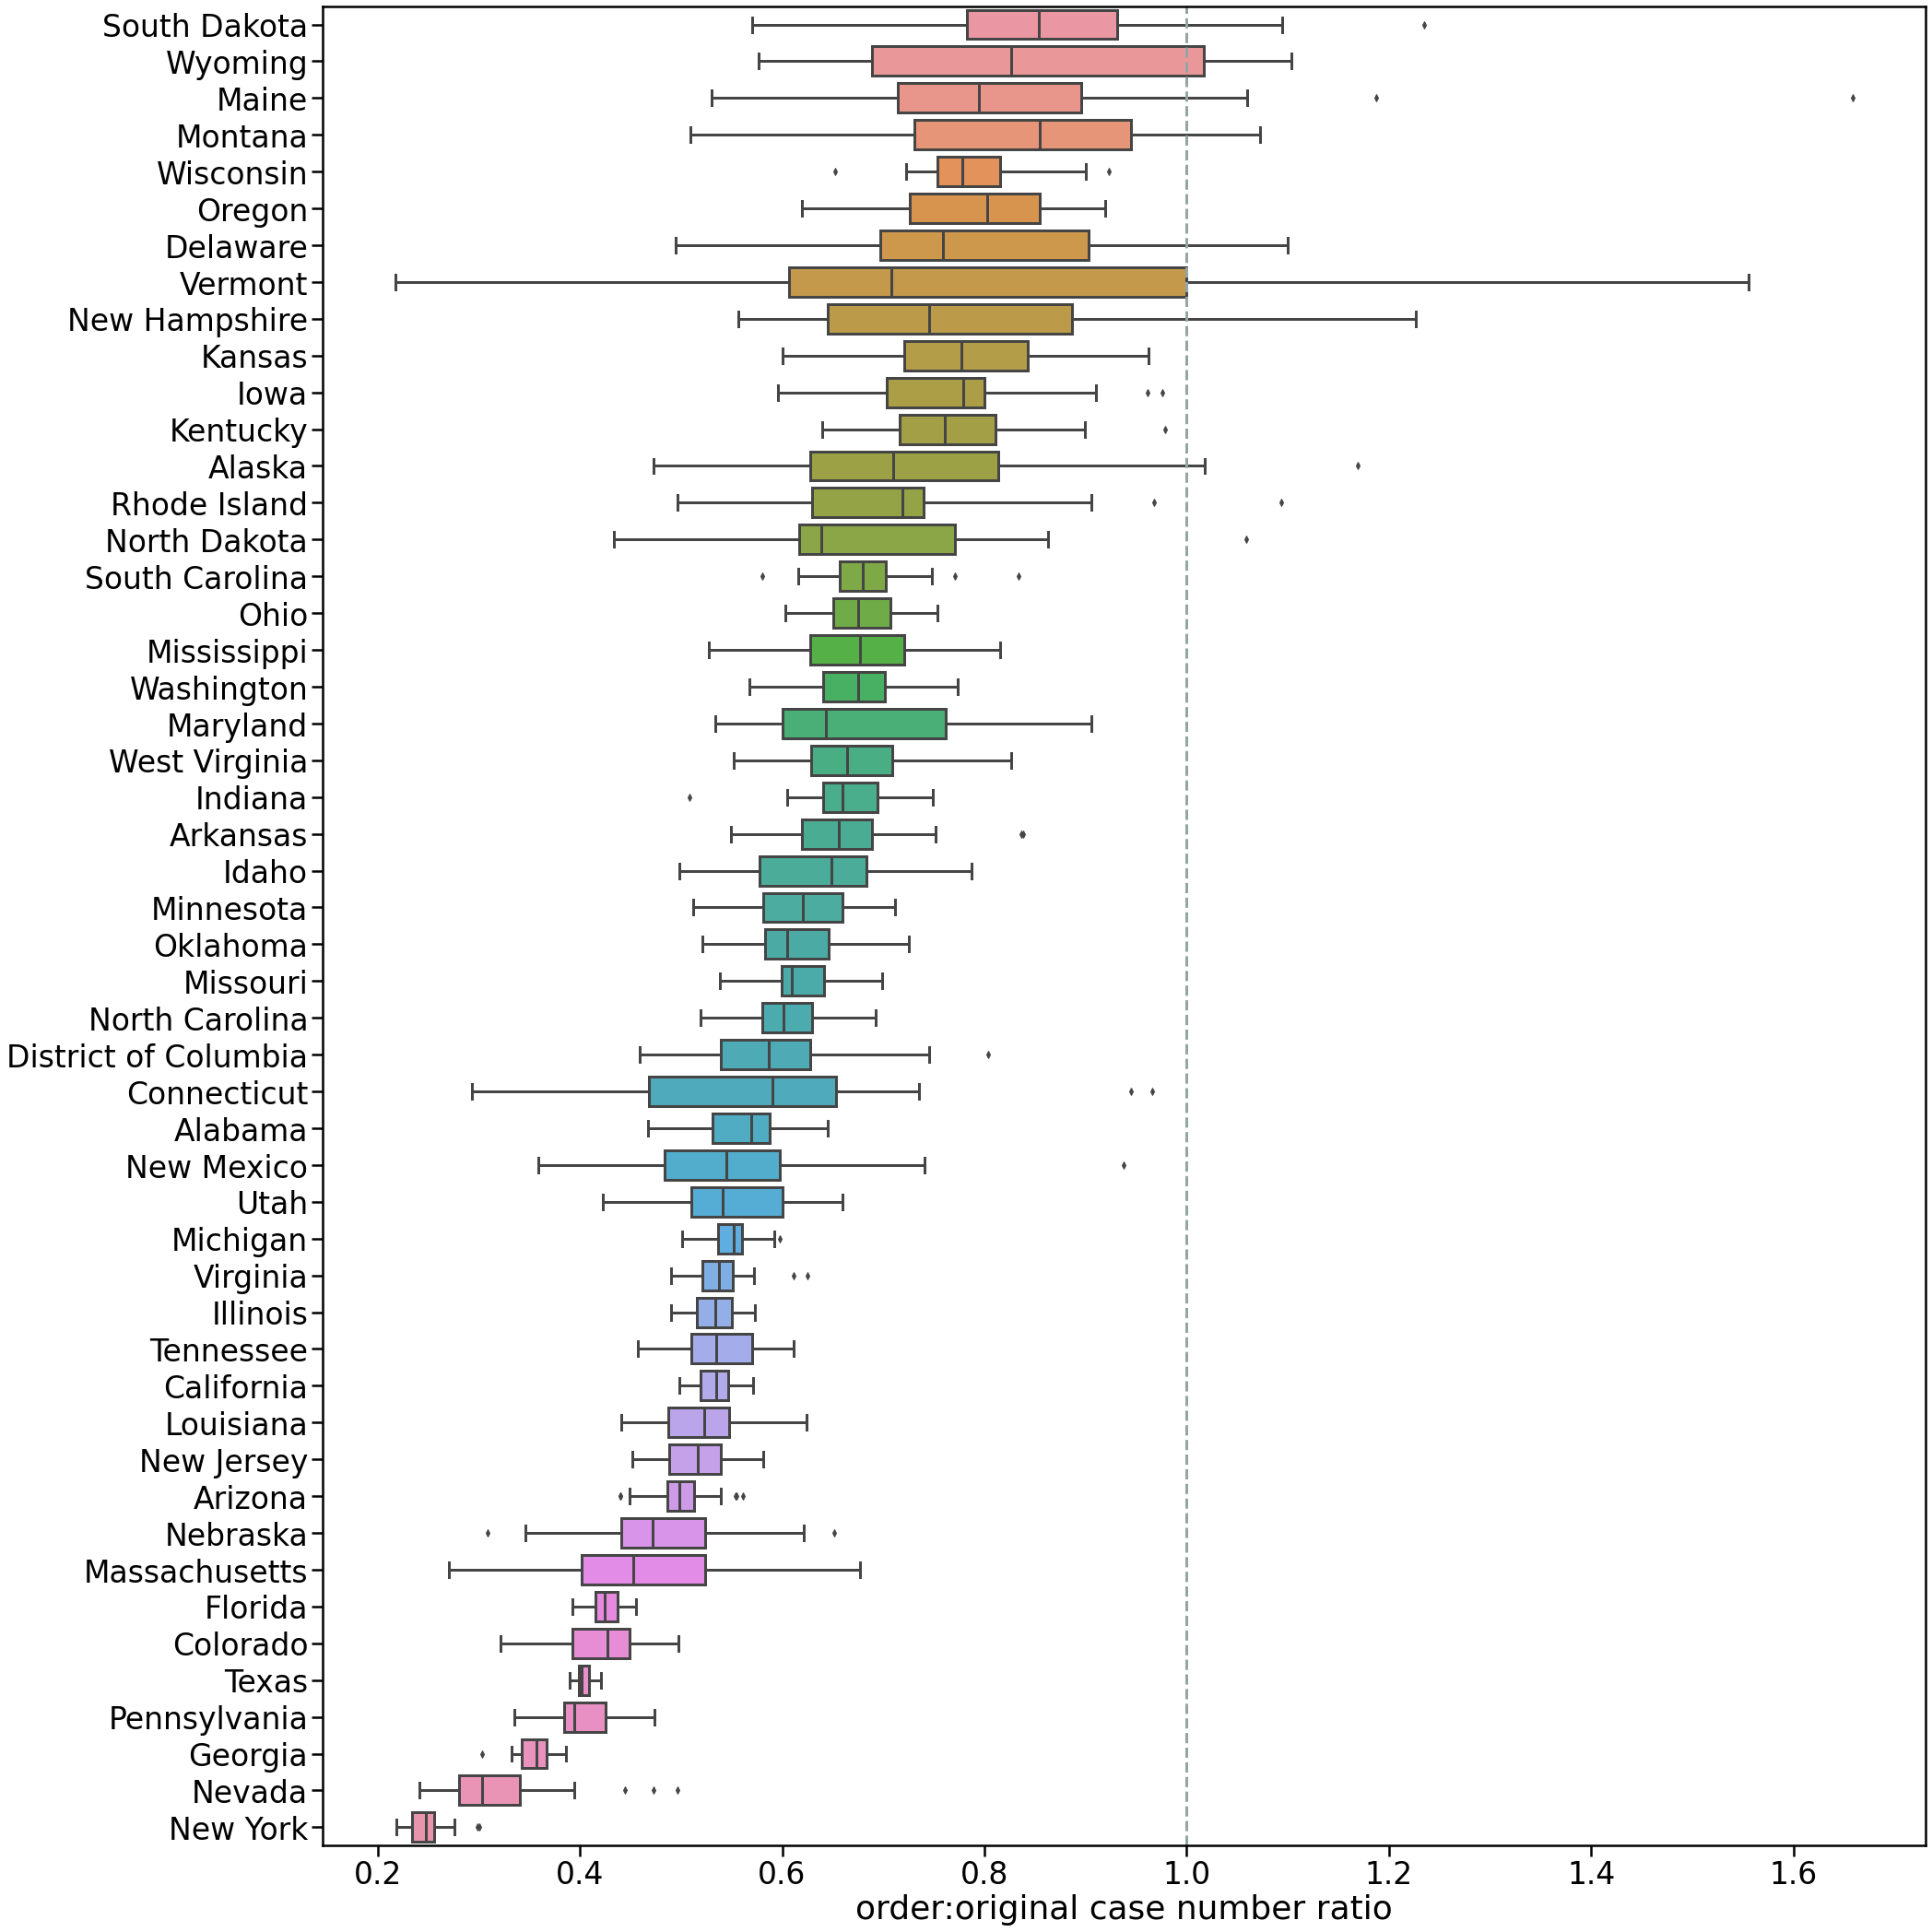

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 30))

sns.set_context('poster', font_scale=1.5)

ranks = data.groupby("state")["order_ratio"].mean().fillna(0).sort_values()[::-1].index

sns.boxplot(x='order_ratio', y='state', data=data, order=ranks)

plt.xlabel('order:original case number ratio')
plt.axvline(1, linestyle='--', color='#95a5a6')
plt.ylabel('')
plt.tight_layout()


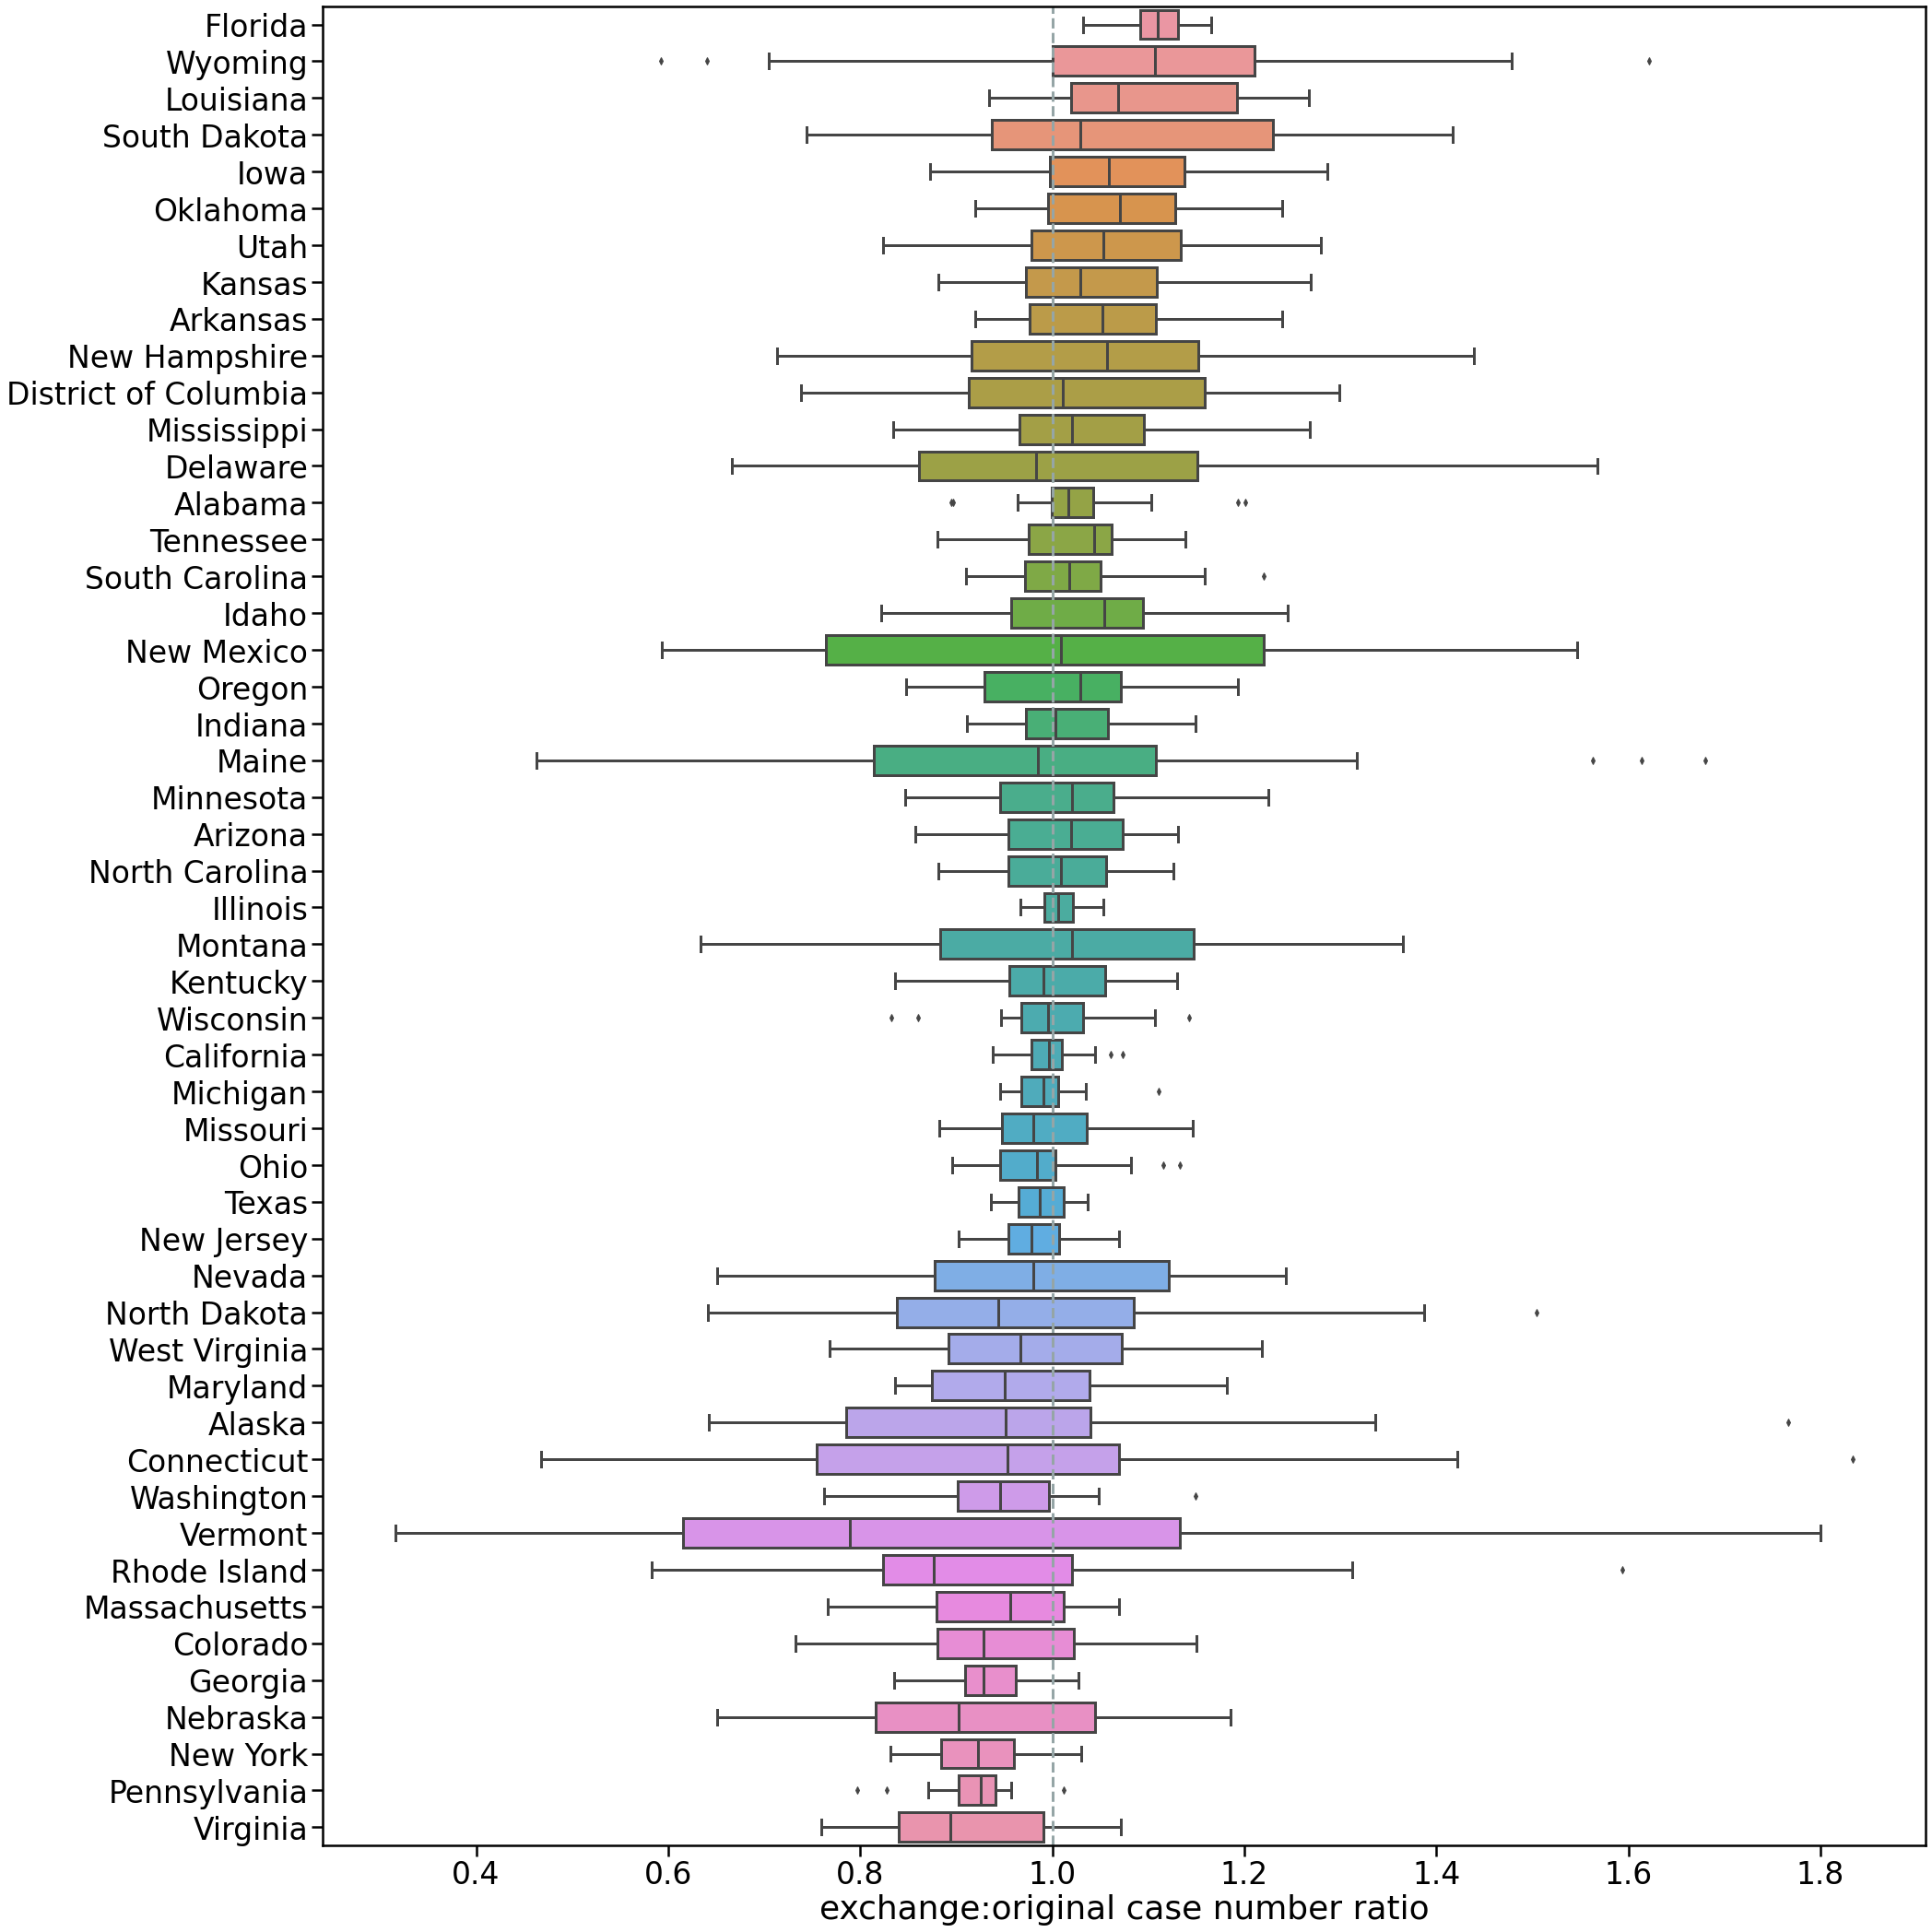

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 30))

sns.set_context('poster', font_scale=1.5)

ranks = data.groupby("state")["exchange_ratio"].mean().fillna(0).sort_values()[::-1].index

sns.boxplot(x='exchange_ratio', y='state', data=data, order=ranks)

plt.xlabel('exchange:original case number ratio')
plt.axvline(1, linestyle='--', color='#95a5a6')
plt.ylabel('')
plt.tight_layout()


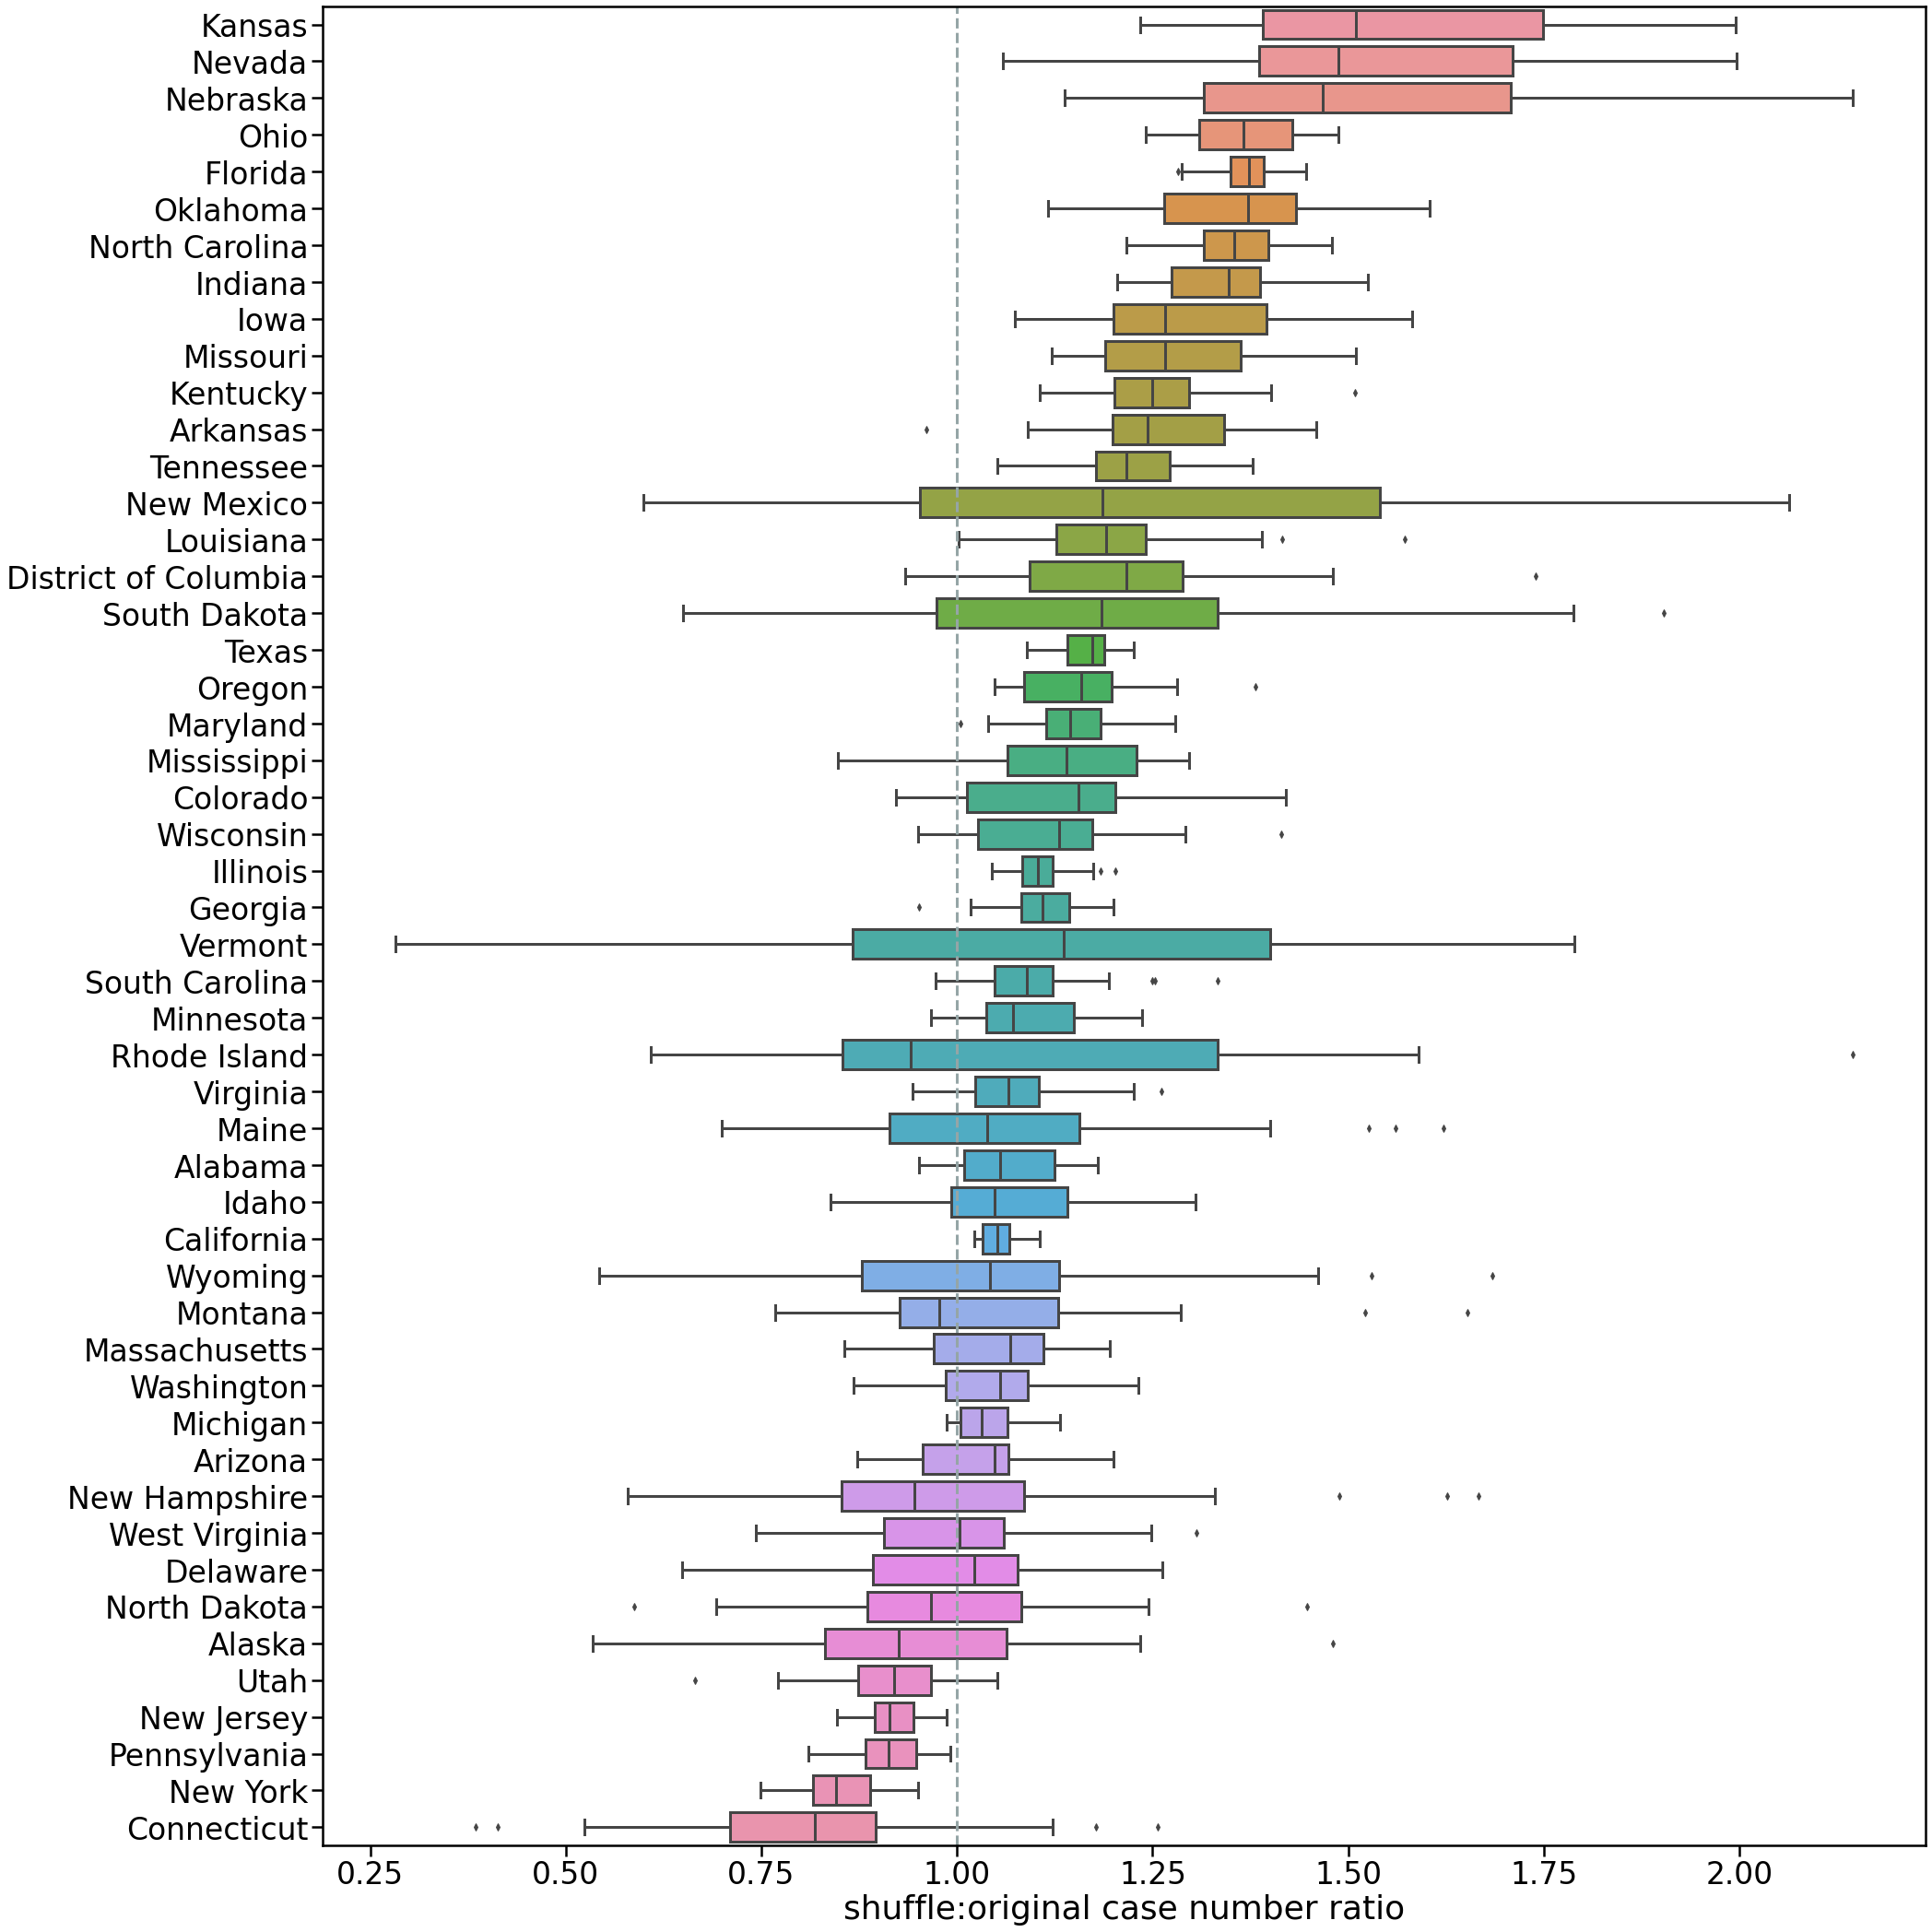

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 30))

sns.set_context('poster', font_scale=1.5)

ranks = data.groupby("state")["shuffle_ratio"].mean().fillna(0).sort_values()[::-1].index

sns.boxplot(x='shuffle_ratio', y='state', data=data, order=ranks)

plt.xlabel('shuffle:original case number ratio')
plt.axvline(1, linestyle='--', color='#95a5a6')
plt.ylabel('')
plt.tight_layout()
